In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/gender_bias_mitigation/gender_bias_mitigation


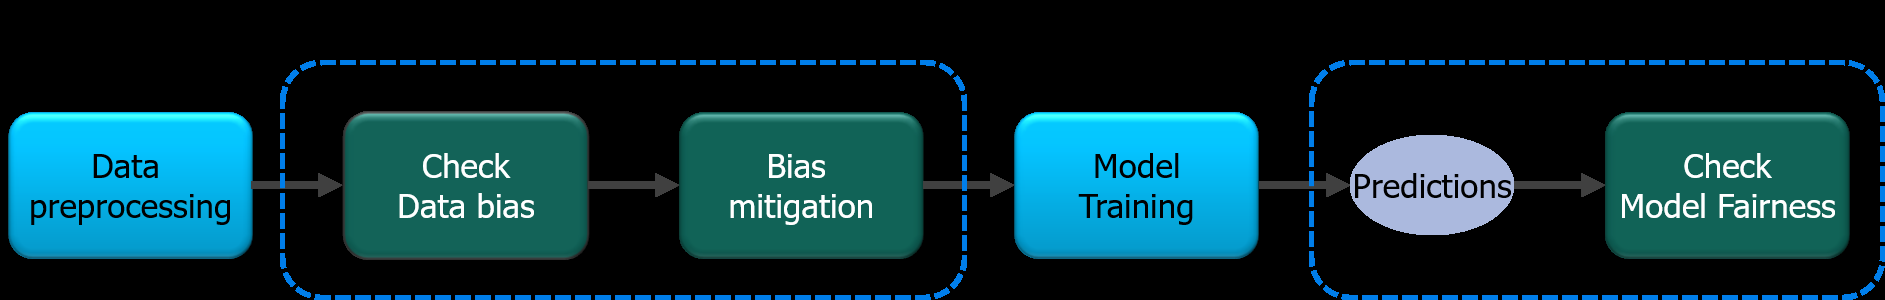

In [6]:
# Preparation
%cd /content/drive/MyDrive/gender_bias_mitigation/gender_bias_mitigation/

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/xai-bias-mitigation-workflow.png')
cv2_imshow(img)

### 1.3 German credit dataset :
[German Credit dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) has classification of people into good/bad credit categories. It has 1000 instances and 20 features.

In this dataset, one may observe age/gender playing significant role in the prediction of credit risk label. Instances with one gender may be favored and other gender[s] may be discriminated against by ML models.

So, we must be aware of the following: <br>
* Training dataset may not be representative of the true population across age/gender groups
* Even if it is representative of the population, it is not fair to base any decision on applicant's age/gender

Let us get our hands dirty with the dataset. We shall determine presence of such biases in this dataset, try using a preprocessing algorithm to mitigate the bias and then evaluate model and data fairness.

In [7]:
import copy
import pandas as pd # for tabular data

import matplotlib.pyplot as plt # to plot charts
import seaborn as sns # to make pretty charts
from collections import defaultdict
import numpy as np # for math

# # sklearn to work with ML models, splitting the train-test data as well as imported metrics
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
from utils import *
%matplotlib inline

In [8]:
import numpy as np
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd # for tabular data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc

###sys.path.append('../Ethics_in_Data/utils/')
sys.path.insert(0,'/content/drive/My Drive/utils/')
##!cp /content/drive/MyDrive/Ethics_in_Data/utils/data_loader.py /content

# import data_loader
# from data_loader import *
# from data_process import *

## 2. Data preparation
#### Load dataset
First, let’s load [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data). Column names as listed in [`german.doc`](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc)

In [9]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataframe = load_dataset(filepath)
dataframe.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


#### Dataset specific preprocessing


In [10]:
# To keep it simple, in this lab, we shall try to determine whether there is gender bias in the dataset
# and mitigate that.
protected_attribute_names = ['gender']
privileged_classes = [['male']]
sensitive_attribute = 'gender'
# derive the gender attribute from personal_status (you can refer the german.doc)
status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
              'A92': 'female', 'A95': 'female'}
dataframe['gender'] = dataframe['personal_status'].replace(status_map)

# target variable
target_attribute = label_name = 'credit'

favorable_label = 1.0  # good credit
unfavorable_label = 0.0  # bad credit
categorical_features = ['status', 'credit_history', 'purpose',
                        'savings', 'employment', 'other_debtors', 'property',
                        'installment_plans', 'housing', 'skill_level', 'telephone',
                        'foreign_worker']
features_to_drop = ['personal_status']

# dataset specific preprocessing
dataframe = preprocess_dataset(dataframe, label_name, protected_attribute_names,
                               privileged_classes, favorable_class=favorable_label,
                               categorical_features=categorical_features,
                               features_to_drop=features_to_drop)
dataframe.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,credit,gender,status=A11,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,6,1169,4,4,67,2,1,1,1.0,1,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,0.0,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,1.0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1.0,1,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,0,1.0,1,...,0,1,0,0,1,0,1,0,1,0


Split the preprocessed data set into train and test data i.e,how well does the trained model perform on unseen data (test data)?

In [11]:
train = dataframe.sample(frac=0.7, random_state=0)
test = dataframe.drop(train.index)

In [13]:
# train

#DATASET

In [14]:
X_train = train.drop(columns = 'credit',axis=1)
X_test = test.drop(columns = 'credit',axis=1)
Y_train = train['credit']
Y_test = test['credit']


In [15]:
type(Y_test)

pandas.core.series.Series

In [16]:
# return `True` if the corresponding row satisfies the `condition` and `False` otherwise
def get_condition_vector(X, feature_names, condition=None):
    if condition is None:
        return np.ones(X.shape[0], dtype=bool)

    overall_cond = np.zeros(X.shape[0], dtype=bool)
    for group in condition:
        group_cond = np.ones(X.shape[0], dtype=bool)
        for name, val in group.items():
            index = feature_names.index(name)
            group_cond = np.logical_and(group_cond, X[:, index] == val)
        overall_cond = np.logical_or(overall_cond, group_cond)

    return overall_cond

In [17]:
def get_num_pos_neg(X, y, w, feature_names, label, condition=None):
    """
    Returns number of optionally conditioned positives/negatives
    """

    y = y.ravel()
    cond_vec = get_condition_vector(X, feature_names, condition=condition)
    return np.sum(w[np.logical_and(y == label, cond_vec)], dtype=np.float64)

In [18]:
def get_num_instances(X, w, feature_names, condition=None):
    cond_vec = get_condition_vector(X, feature_names, condition)

    return np.sum(w[cond_vec], dtype=np.float64)

In [19]:

def get_base_rate(X, y, w, feature_names, label, condition=None):
    return (get_num_pos_neg(X, y, w, feature_names, label, condition=condition)
            / get_num_instances(X, w, feature_names, condition=condition))

In [20]:
labels_train = train[label_name].values.copy()

# protected attributes
df_prot = train.loc[:, protected_attribute_names]
protected_attributes = df_prot.values.copy()
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

# equal weights for all classes by default in the train dataset
instance_weights = np.ones_like(train.index, dtype=np.float64)

In [21]:
def statistical_parity_difference(X, y, w, feature_names, label, privileged_groups,
                                  unprivileged_groups):
    """
    Compute difference in the metric between unprivileged and privileged groups.
    """

    positive_privileged = get_base_rate(X, y, w, feature_names, label, privileged_groups)
    positive_unprivileged = get_base_rate(X, y, w, feature_names, label, unprivileged_groups)
    return (positive_unprivileged - positive_privileged)

In [22]:
def disparate_impact(X, y, w, feature_names, label, privileged_groups,
                                  unprivileged_groups):
    """
    Compute the ratio of the metric between unprivileged and privileged groups.
    """

    positive_privileged = get_base_rate(X, y, w, feature_names, label, privileged_groups)
    positive_unprivileged = get_base_rate(X, y, w, feature_names, label, unprivileged_groups)
    return (positive_unprivileged/positive_privileged)

In [23]:
original_spd = statistical_parity_difference(protected_attributes,
                                         labels_train, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)
original_di = disparate_impact(protected_attributes,
                                         labels_train, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)

In [24]:
original_spd

-0.10807017543859643

In [25]:
original_di

0.8529130850047756

In [26]:
print(f"Before Data debiasing : SPD {(original_spd)} Disparate Impact : {(original_di)}" )

Before Data debiasing : SPD -0.10807017543859643 Disparate Impact : 0.8529130850047756


# Reweighing algorithm

In [27]:
# get the only privileged condition vector for the given protected attributes
# Values are `True` for the privileged values else 'False'
privileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=privileged_groups)

# Get the only unprivileged condition vector for the given protected attributes
# Values are `True` for the unprivileged values else 'False)
unprivileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=unprivileged_groups)

In [28]:
# get the favorable(postive outcome) condition vector
# Values are `True` for the favorable values else 'False'
favorable_cond = labels_train.ravel() == favorable_label

# get the unfavorable condition vector
# Values are `True` for the unfavorable values else 'False'
unfavorable_cond = labels_train.ravel() == unfavorable_label

In [29]:
# combination of label and privileged/unprivileged groups

# Postive outcome for privileged group
privileged_favorable_cond = np.logical_and(favorable_cond, privileged_cond)

# Negative outcome for privileged group
privileged_unfavorable_cond = np.logical_and(unfavorable_cond, privileged_cond)

# Postive outcome for unprivileged group
unprivileged_favorable_cond = np.logical_and(favorable_cond, unprivileged_cond)

# Negative outcome for unprivileged group
unprivileged_unfavorable_cond = np.logical_and(unfavorable_cond, unprivileged_cond)

In [30]:
instance_count = train.shape[0]
privileged_count = np.sum(privileged_cond, dtype=np.float64)
unprivileged_count = np.sum(unprivileged_cond, dtype=np.float64)
favourable_count = np.sum(favorable_cond, dtype=np.float64)
unfavourable_count = np.sum(unfavorable_cond, dtype=np.float64)

privileged_favourable_count = np.sum(privileged_favorable_cond, dtype=np.float64)
privileged_unfavourable_count = np.sum(privileged_unfavorable_cond, dtype=np.float64)
unprivileged_favourable_count = np.sum(unprivileged_favorable_cond, dtype=np.float64)
unprivileged_unfavourable_count = np.sum(unprivileged_unfavorable_cond, dtype=np.float64)

In [31]:
# reweighing weights
weight_privileged_favourable = favourable_count * privileged_count / (instance_count * privileged_favourable_count)
weight_privileged_unfavourable = unfavourable_count * privileged_count / (instance_count * privileged_unfavourable_count)
weight_unprivileged_favourable = favourable_count * unprivileged_count / (instance_count * unprivileged_favourable_count)
weight_unprivileged_unfavourable = unfavourable_count * unprivileged_count / (instance_count * unprivileged_unfavourable_count)

In [32]:
transformed_instance_weights = copy.deepcopy(instance_weights)

In [33]:
transformed_instance_weights[privileged_favorable_cond] *= weight_privileged_favourable
transformed_instance_weights[privileged_unfavorable_cond] *= weight_privileged_unfavourable
transformed_instance_weights[unprivileged_favorable_cond] *= weight_unprivileged_favourable
transformed_instance_weights[unprivileged_unfavorable_cond] *= weight_unprivileged_unfavourable

In [34]:
mitigated_spd = statistical_parity_difference(protected_attributes,
                                          labels_train, transformed_instance_weights,
                                          protected_attribute_names, favorable_label,
                                          privileged_groups, unprivileged_groups)
mitigated_di = disparate_impact(protected_attributes,
                                          labels_train, transformed_instance_weights,
                                          protected_attribute_names, favorable_label,
                                          privileged_groups, unprivileged_groups)

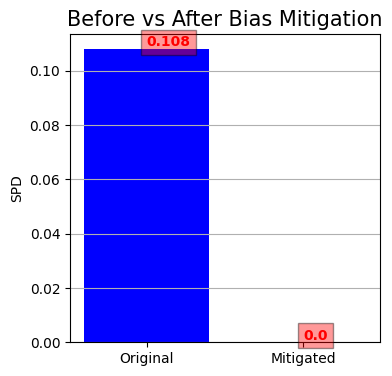

In [35]:
plot_fairness_comp(abs(original_spd),abs(mitigated_spd),metric="SPD")

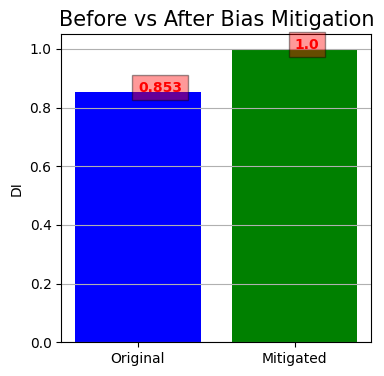

In [36]:
plot_fairness_comp(abs(original_di),abs(mitigated_di),metric="DI")

# Preferential Sampling algorithm

In [37]:
def preferential_sampling(df, df_c, class_attribute, favourable_class, un_favourable_class, df_s, sensitive_attribute, privileged_class, unprivileged_class):
    # Separate four groups based on sensitive attribute  and class attribute: DP, DN, PP, PN
    df = pd.concat([df, df_c], axis=1)
    DP = df[(df_s[sensitive_attribute] == unprivileged_class) & (df_c[class_attribute] == favourable_class)]
    DN = df[(df_s[sensitive_attribute] == unprivileged_class) & (df_c[class_attribute] == un_favourable_class)]
    PP = df[(df_s[sensitive_attribute] == privileged_class) & (df_c[class_attribute] == favourable_class)]
    PN = df[(df_s[sensitive_attribute] == privileged_class) & (df_c[class_attribute] == un_favourable_class)]

    # Learn a ranking model ranker on D
    ranker = RandomForestClassifier(random_state=42)
    X = df.drop([class_attribute], axis=1)
    y = df[class_attribute]
    ranker.fit(X, y)
    # Arrange the elements of DP and PP in ascending order
    # DN and PN in descending order
    DP_sorted = DP.assign(ranker_score=ranker.predict_proba(DP.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score')
    PP_sorted = PP.assign(ranker_score=ranker.predict_proba(PP.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score')
    DN_sorted = DN.assign(ranker_score=ranker.predict_proba(DN.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score', ascending=False)
    PN_sorted = PN.assign(ranker_score=ranker.predict_proba(PN.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score', ascending=False)

    # Step 4: Calculate the expected size for each combination of v ∈ SenstiveAttribute and c ∈ ClassAttribute by |v| * |c| / |D|
    expected_sizes = {}
    for v in [privileged_class, unprivileged_class]:
        for c in [favourable_class, un_favourable_class]:
            expected_sizes[(v, c)] = (len(df[df[sensitive_attribute] == v]) * len(
                df[df[class_attribute] == c])) / len(df)

    DP_resampled = pd.DataFrame()
    PN_resampled = pd.DataFrame()
    DN_resampled = pd.DataFrame()
    PP_resampled = pd.DataFrame()

    for v in [privileged_class, unprivileged_class]:
        for c in [favourable_class, un_favourable_class]:
            expected_size = expected_sizes[(v, c)]
            group = df[(df[sensitive_attribute] == v) & (df_c[class_attribute] == c)]
            size_of_group = len(group)
            no_resubstitution_skipping = round(abs(expected_size - size_of_group))
            if expected_size > len(group):
                if v == unprivileged_class and c == favourable_class:
                    if no_resubstitution_skipping > len(group):
                        n_repeats = int(expected_size // size_of_group)
                        DP_resampled = pd.concat([DP_sorted]*n_repeats)
                        n_remaining = int(expected_size % size_of_group)
                        if n_remaining > 0:
                            DP_resampled = pd.concat([DP_resampled,DP_sorted.head(n_remaining)])
                    else:
                        DP_resampled = pd.concat([DP_sorted[:no_resubstitution_skipping], DP_sorted])
                if v == privileged_class and c == un_favourable_class:
                    if no_resubstitution_skipping > len(group):
                        n_repeats = int(expected_size // size_of_group)
                        PN_resampled = pd.concat([PN_sorted]*n_repeats)
                        n_remaining = int(expected_size % size_of_group)
                        if n_remaining > 0:
                            DP_resampled = pd.concat([PN_resampled,PN_sorted.head(n_remaining)])
                    PN_resampled = pd.concat([PN_sorted[:no_resubstitution_skipping], PN_sorted])
            elif expected_size < len(group):
                if v == unprivileged_class and c == un_favourable_class:
                    DN_resampled = DN_sorted[no_resubstitution_skipping:]
                if v == privileged_class and c == favourable_class:
                    PP_resampled = PP_sorted[no_resubstitution_skipping:]
            else:
                if v == privileged_class and c == favourable_class:
                    PP_resampled = group
                if v == unprivileged_class and c == un_favourable_class:
                    DN_resampled = group
                if v == privileged_class and c == un_favourable_class:
                    PN_resampled = group
                if v == unprivileged_class and c == favourable_class:
                    DP_resampled = group
    resampled_df = pd.concat([DP_resampled, PN_resampled, DN_resampled, PP_resampled])
    resampled_features = resampled_df.drop([class_attribute, 'ranker_score'], axis=1)
    resampled_protected_attr = resampled_df[sensitive_attribute].to_frame()
    resampled_class_attr = resampled_df[class_attribute].to_frame()
    return resampled_features, resampled_protected_attr, resampled_class_attr

In [38]:
X_test.head(2)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,gender,status=A11,status=A12,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
9,30,5234,4,2,28,2,1,1.0,0,1,...,1,0,0,0,0,1,1,0,1,0
11,48,4308,3,4,24,1,1,0.0,1,0,...,0,0,0,0,1,0,1,0,1,0


In [40]:
Z_train = X_train['gender']
Z_train.head(2)

993    1.0
859    1.0
Name: gender, dtype: object

In [45]:
Z_train = pd.DataFrame(Z_train, columns=['gender'])
Z_train.head(2)

,gender
993,1.0
859,1.0


In [51]:
Z_test= X_test['gender']
Z_test.head(2)

9     1.0
11    0.0
Name: gender, dtype: object

In [52]:
Z_test = pd.DataFrame(Z_test, columns=['gender'])
Z_test.head(2)

,gender
9,1.0
11,0.0


In [53]:
Y_train.head(2)

993    1
859    1
Name: credit, dtype: int64

In [55]:
Y_train = pd.DataFrame(Y_train, columns=['credit'])
Y_train.head(2)

,credit
993,1
859,1


In [57]:
Y_test.head(2)

9     0
11    0
Name: credit, dtype: int64

In [58]:
Y_test = pd.DataFrame(Y_test, columns=['credit'])
Y_test.head(2)

,credit
9,0
11,0


In [59]:
resampled_features, resampled_protected_attr, resampled_class_attr = preferential_sampling(X_train, Y_train, target_attribute, 1, 0, Z_train, 'gender', 1,0)

In [66]:
resampled_protected_attr.head(2)

,gender
285,0.0
14,0.0


In [65]:
resampled_class_attr.head(2)

,credit
285,1
14,1


In [64]:
resampled_features.head(2)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,gender,status=A11,status=A12,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
285,47,10722,1,1,35,1,1,0.0,1,0,...,1,0,0,1,0,0,0,1,1,0
14,15,1403,2,4,28,1,1,0.0,1,0,...,0,0,0,0,1,0,1,0,1,0


In [67]:
labels_train_resampled_protected_attr = resampled_class_attr.values.copy()

In [68]:
protected_attributes_resampled_protected_attr = resampled_protected_attr.values.copy()

In [69]:
after_sampling_spd = statistical_parity_difference(protected_attributes_resampled_protected_attr,
                                         labels_train_resampled_protected_attr, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)
after_sampling_di = disparate_impact(protected_attributes_resampled_protected_attr,
                                         labels_train_resampled_protected_attr, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)

In [70]:
after_sampling_spd

-0.0032748538011695416

In [71]:
after_sampling_di

0.9953286619953288

In [75]:
def plot_fairness_comp_sampled(original, mitigated, metric="DPD"):
    """
    Args:
        original: original bias of the dataset
        mitigated: mitigated bias of the dataset
        metric: name of the fairness metric

    Returns:
        plot the fairness comparison

    """
    plt.figure(facecolor='#FFFFFF', figsize=(4, 4))
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.bar(["Original", "after_sampling"], [
            original, mitigated], color=["blue", "green"])
    plt.ylabel(metric)
    plt.title("Before vs After Bias Mitigation", fontsize=15)
    y = [original, mitigated]
    for index, value in enumerate(y):
        if value < 0:
            plt.text(index, value - 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
        else:
            plt.text(index, value + 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
    plt.grid(None, axis="y")
    plt.show()

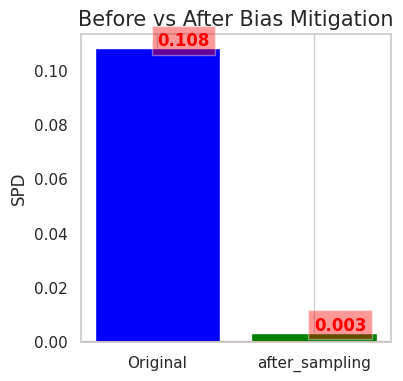

In [76]:
plot_fairness_comp_sampled(abs(original_spd),abs(after_sampling_spd),metric="SPD")

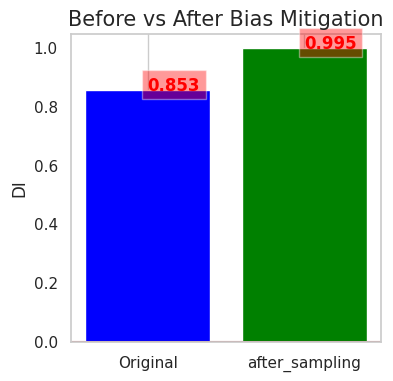

In [77]:
plot_fairness_comp_sampled(abs(original_di),abs(after_sampling_di),metric="DI")

In [81]:
def plot_fairness_comp_sampled_reweighted(original, mitigated,sampled, metric="DPD"):
    """
    Args:
        original: original bias of the dataset
        mitigated: mitigated bias of the dataset
        metric: name of the fairness metric

    Returns:
        plot the fairness comparison

    """
    plt.figure(facecolor='#FFFFFF', figsize=(4, 4))
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.bar(["Original","reweighting", "after_sampling"], [
            original, mitigated, sampled], color=["blue", "green", "yellow"])
    plt.ylabel(metric)
    plt.title("Before vs After Bias Mitigation", fontsize=15)
    y = [original, mitigated, sampled]
    for index, value in enumerate(y):
        if value < 0:
            plt.text(index, value - 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
        else:
            plt.text(index, value + 0.001,
                     str(round(value, 3)), fontweight='bold', color='red',
                     bbox=dict(facecolor='red', alpha=0.4))
    plt.grid(None, axis="y")
    plt.show()

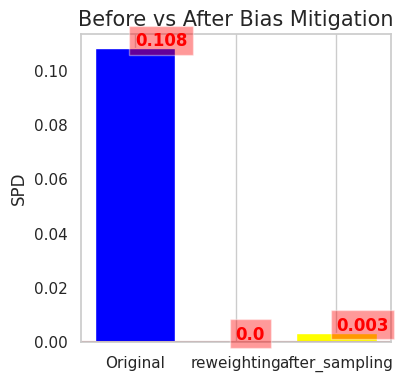

In [82]:
plot_fairness_comp_sampled_reweighted(abs(original_spd),abs(mitigated_spd),abs(after_sampling_spd),metric="SPD")

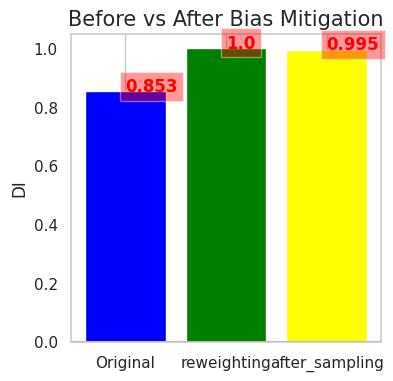

In [83]:
plot_fairness_comp_sampled_reweighted(abs(original_di),abs(mitigated_di),abs(after_sampling_di),metric="DI")

#Training

## on normal data set

In [84]:
import copy
import pandas as pd # for tabular data

import matplotlib.pyplot as plt # to plot charts
import seaborn as sns # to make pretty charts
from collections import defaultdict
import numpy as np # for math

# # sklearn to work with ML models, splitting the train-test data as well as imported metrics
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
from utils import *
%matplotlib inline

In [85]:
import xgboost as xgb  # Importing the XGBoost module


In [86]:
# # split the features and labels for both train and test data
# feature_names = [n for n in train.columns if n not in label_name]
# X_train, X_test, Y_train, Y_test = train[feature_names].values.copy(), test[
#     feature_names].values.copy(), train[label_name].values.copy(), test[label_name].values.copy()
# # standardize the inputs
scale_orig = StandardScaler()
X_train_normal = scale_orig.fit_transform(X_train)
X_test_normal = scale_orig.transform(X_test)

In [87]:
models = []
models.append(('LR', LogisticRegression(max_iter=500,random_state=42)))
models.append(('GBC', GradientBoostingClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('XGB', xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)))

In [88]:
def get_model_fairness(y, privileged_group, preds):
    """
    Get the model fairness

    Args:
        y: True labels for the data
        privileged_group: privileged group for which we want to check fairness
        preds: predicted probabilities for the positive class

    Returns:
        demographic parity(dpd),disparate_impact(di),
        equal opportunity difference(eod),
        equalised odds(AAOD)

    """
    y_unprivileged, preds_unprivileged = y[privileged_group == False], preds[
        privileged_group == False]
    y_privileged, preds_privileged = y[privileged_group], preds[privileged_group]
    cm_unprivileged = confusion_matrix(y_unprivileged, preds_unprivileged)
    cm_privileged = confusion_matrix(y_privileged, preds_privileged)

    unprivileged_PR = (
        cm_unprivileged[1, 1] + cm_unprivileged[0, 1]) / cm_unprivileged.sum()
    privileged_PR = (cm_privileged[1, 1] +
                     cm_privileged[0, 1]) / cm_privileged.sum()
    dpd = unprivileged_PR - privileged_PR
    di = unprivileged_PR / privileged_PR
    unprivileged_TPR = cm_unprivileged[1, 1] / cm_unprivileged[1].sum()
    privileged_TPR = cm_privileged[1, 1] / cm_privileged[1].sum()
    eod = unprivileged_TPR - privileged_TPR

    unprivileged_FPR = cm_unprivileged[0, 1] / cm_unprivileged[0].sum()
    privileged_FPR = cm_privileged[0, 1] / cm_privileged[0].sum()
    aaod = 0.5 * (
            abs(unprivileged_FPR - privileged_FPR) + abs(unprivileged_TPR - privileged_TPR))
    return dpd, di, eod, aaod


In [90]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, X_train_normal, Y_train.values.ravel())
    y_score = clf.predict_proba(X_test_normal)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)

    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==1,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.78 DPD : 0.223 ,DI : 0.737, EOD : 0.187 , AAOD : 0.253
Model : GBC accuracy : 0.76 DPD : 0.115 ,DI : 0.858, EOD : 0.113 , AAOD : 0.121
Model : RF accuracy : 0.77 DPD : 0.131 ,DI : 0.843, EOD : 0.06 , AAOD : 0.185
Model : XGB accuracy : 0.74 DPD : 0.149 ,DI : 0.808, EOD : 0.14 , AAOD : 0.159


In [91]:
before_any_application = defaultdict(dict)
before_any_application["DPD"] = dpd_list
before_any_application["DI"] = di_list
before_any_application["Accuracy"] = accuracy_list
before_any_application["AUC"] = roc_auc_list
before_any_application["EOD"] = eod_list
before_any_application["AAOD"] = aaod_list

In [92]:
before_any_application

defaultdict(dict,
            {'DPD': [0.22298221614227087,
              0.11518467852257186,
              0.13132694938440492,
              0.14856361149110808],
             'DI': [0.7365869424692955,
              0.8576741041244084,
              0.8431372549019608,
              0.8075832742735648],
             'Accuracy': [0.7766666666666666,
              0.7566666666666667,
              0.7733333333333333,
              0.7366666666666667],
             'AUC': [0.6944444444444444,
              0.6738095238095239,
              0.6825396825396826,
              0.6722222222222222],
             'EOD': [0.18666666666666665,
              0.11333333333333329,
              0.05999999999999994,
              0.14],
             'AAOD': [0.2533333333333333,
              0.12128205128205125,
              0.18538461538461534,
              0.15923076923076923]})

##resampling data

In [102]:
scale_orig = StandardScaler()
X_train_sampled = scale_orig.fit_transform(resampled_features)
X_test_sampled=scale_orig.transform(X_test)
Y_train_sampled = resampled_class_attr

In [103]:
resampled_protected_attr.head(2)

,gender
285,0.0
14,0.0


In [104]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, X_train_sampled, Y_train_sampled.values.ravel())
    y_score = clf.predict_proba(X_test_sampled)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)

    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==1,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.76 DPD : 0.052 ,DI : 0.936, EOD : 0.04 , AAOD : 0.065
Model : GBC accuracy : 0.78 DPD : 0.031 ,DI : 0.96, EOD : 0.027 , AAOD : 0.039
Model : RF accuracy : 0.8 DPD : 0.052 ,DI : 0.936, EOD : 0.02 , AAOD : 0.127
Model : XGB accuracy : 0.74 DPD : 0.003 ,DI : 0.996, EOD : 0.033 , AAOD : 0.066


In [105]:
after_sampling = defaultdict(dict)
after_sampling["DPD"] = dpd_list
after_sampling["DI"] = di_list
after_sampling["Accuracy"] = accuracy_list
after_sampling["AUC"] = roc_auc_list
after_sampling["EOD"] = eod_list
after_sampling["AAOD"] = aaod_list

#REWEIGHT

In [108]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, X_train_normal, Y_train.values.ravel(),sample_weight = transformed_instance_weights)
    y_score = clf.predict_proba(X_test_normal)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)

    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==1,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.77 DPD : 0.138 ,DI : 0.834, EOD : 0.163 , AAOD : 0.126
Model : GBC accuracy : 0.75 DPD : 0.059 ,DI : 0.926, EOD : 0.067 , AAOD : 0.058
Model : RF accuracy : 0.77 DPD : 0.141 ,DI : 0.834, EOD : 0.09 , AAOD : 0.18
Model : XGB accuracy : 0.75 DPD : 0.132 ,DI : 0.833, EOD : 0.15 , AAOD : 0.124


In [109]:
after_reweight = defaultdict(dict)
after_reweight["DPD"] = dpd_list
after_reweight["DI"] = di_list
after_reweight["Accuracy"] = accuracy_list
after_reweight["AUC"] = roc_auc_list
after_reweight["EOD"] = eod_list
after_reweight["AAOD"] = aaod_list


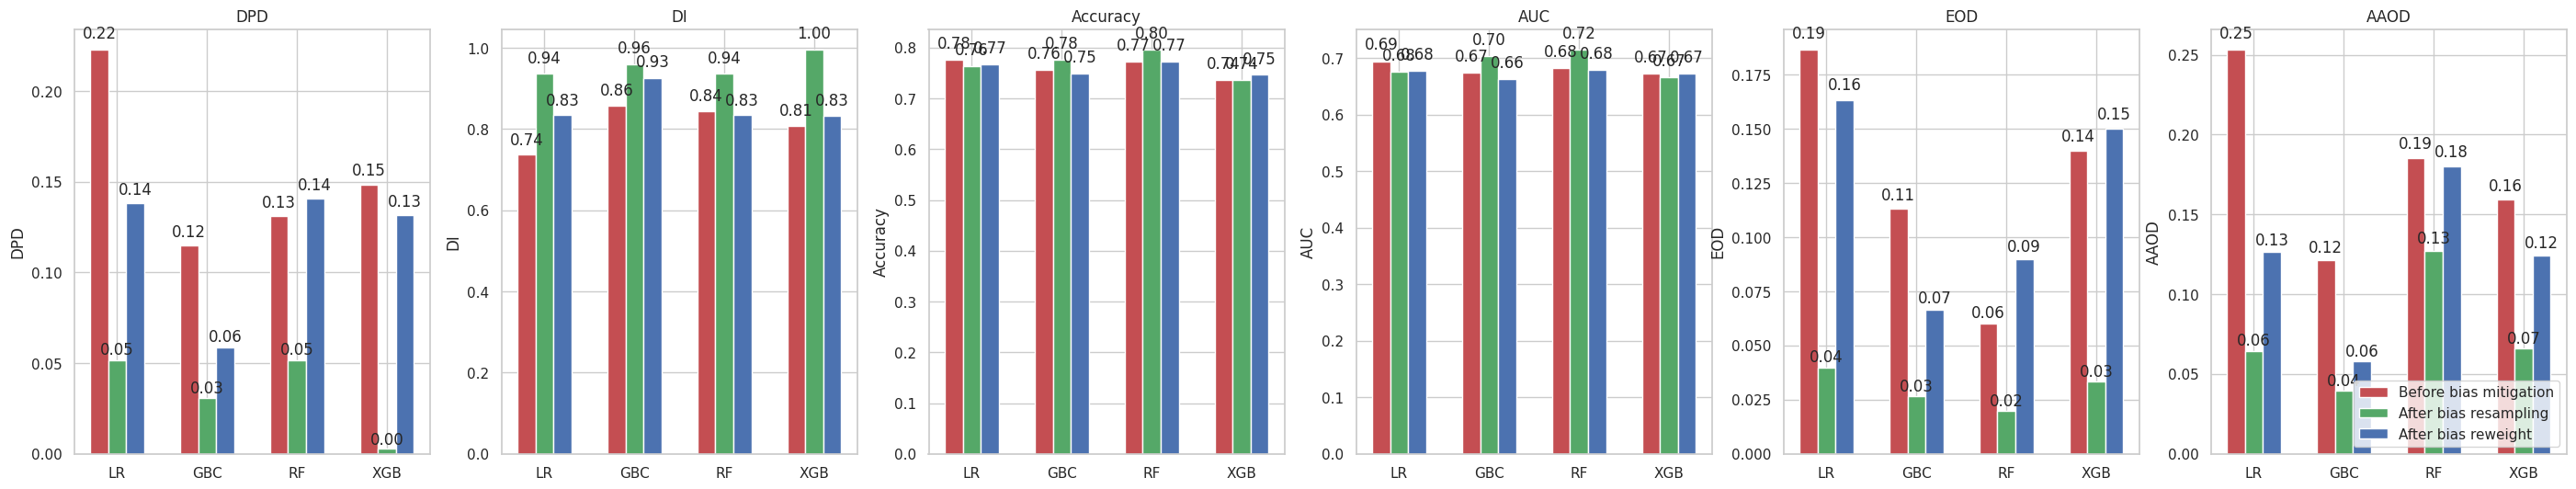

In [128]:

def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(models_names))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 6, figsize=(35, 6))

for ax,metric in zip (axs.ravel(),before_any_application.keys()):
    fairness_base_bar = ax.bar(ind, before_any_application[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_sampling[metric], width, color='g',
                                     label='After bias resampling')
    fairness_mitigated_bar1 = ax.bar(ind + 2*width, after_reweight[metric], width, color='b',
                                     label='After bias reweight')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(models_names)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
    autolabel(fairness_mitigated_bar1, axes=ax)

plt.legend(loc ="lower right")
plt.show()